In [33]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.170
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	:

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from PIL import ImageDraw
from tqdm.notebook import tqdm
import pickle 
from sklearn.utils import shuffle
import matplotlib.pylab as plt # plot module

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is avalible.
Working on: Tesla P100-PCIE-16GB


## Insecting data

train.csv

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MachineLearning/Mango_ML/train.csv',header=None)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,38414.jpg,46,146,576,574,不良-機械傷害,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,03182.jpg,581,277,97,93,不良-機械傷害,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29863.jpg,514,538,117,144,不良-機械傷害,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17937.jpg,658,263,59,74,不良-機械傷害,374.0,243.0,609.0,334.0,不良-著色不佳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40878.jpg,432,160,116,132,不良-機械傷害,620.0,289.0,104.0,100.0,不良-機械傷害,712.0,161.0,60.0,65.0,不良-機械傷害,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


image

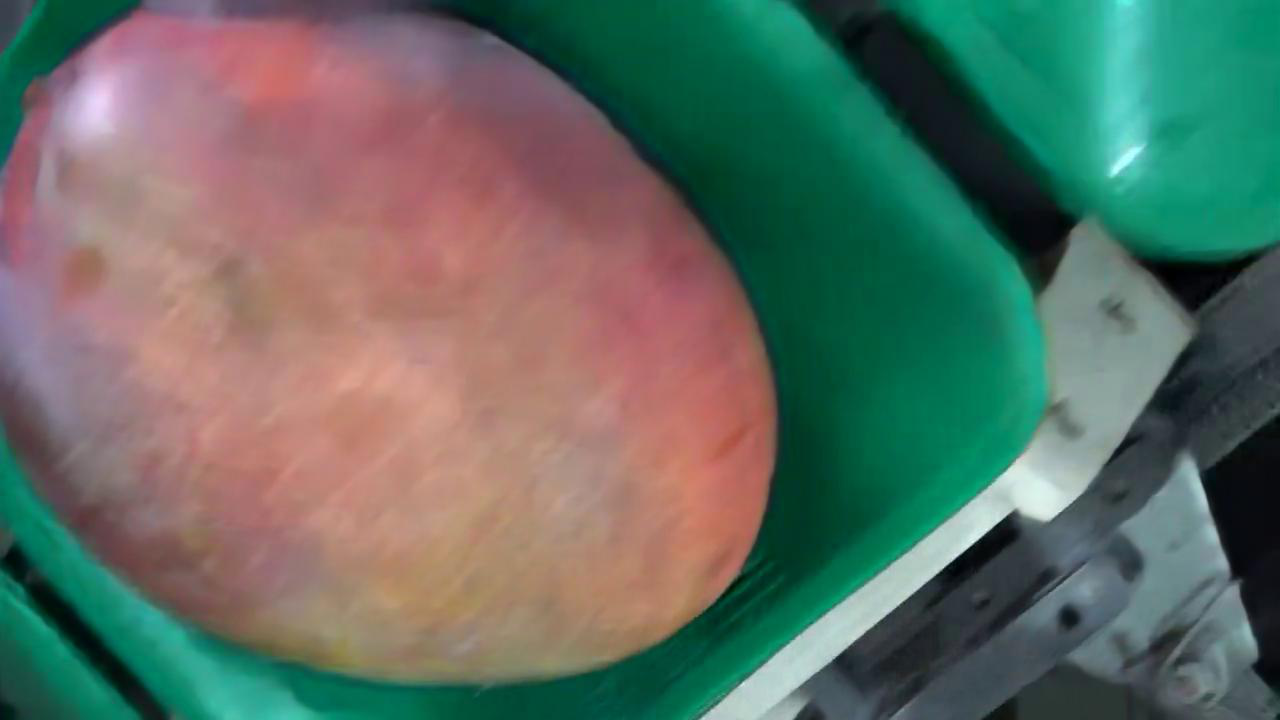

In [11]:
img = Image.open("/content/drive/MyDrive/MachineLearning/Mango_ML/Train/38414.jpg")
img

bbox

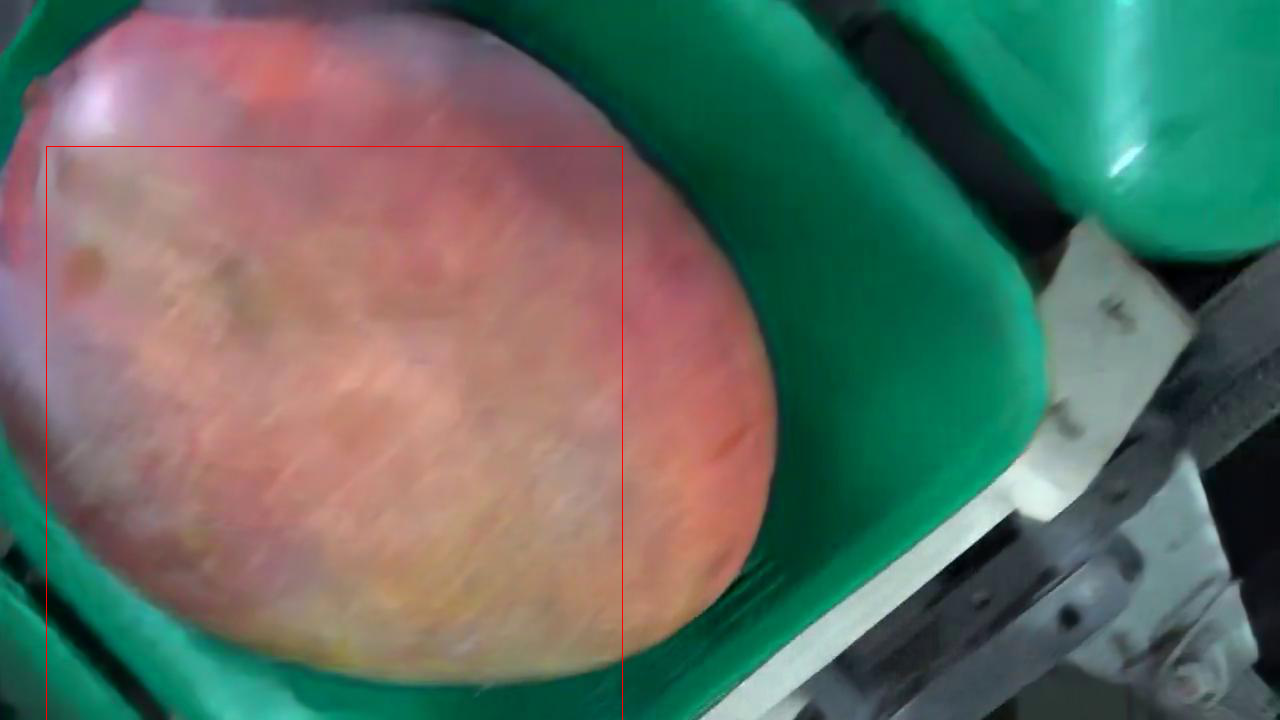

In [12]:
xmin = 46
ymin = 146
xmax = xmin+576
ymax = ymin+574
draw = ImageDraw.Draw(img)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ="red")
img

croped image

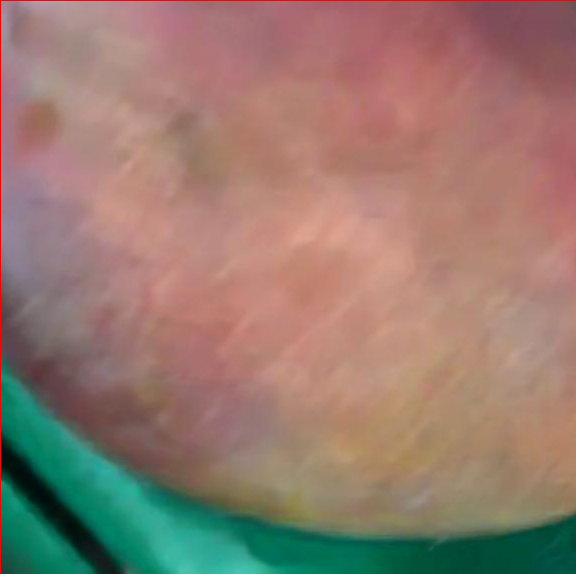

In [13]:
img2 = img.crop((xmin, ymin, xmax, ymax))
img2

## Building defect table

### Train

In [ ]:
import numpy as np
label=[]
image=[]
xmin=[]
ymin=[]
xmax=[]
ymax=[]

with open(r'/content/drive/MyDrive/MachineLearning/Mango_ML/train.csv', 'r', encoding='utf-8-sig') as fh:
  for index,row in enumerate(fh):
    row=row.strip()
    row=row.split(',')
    while True:
      if '' in row:
        row.remove('')
      else:
        break

    while len(row) > 1:
      xmin.append(float(row[1]))
      ymin.append(float(row[2]))
      xmax.append(float(row[3])+float(row[1]))
      ymax.append(float(row[4])+float(row[2]))
      label.append(row[5])
      for idx in range(5):
        row.remove(row[1]) 
      image.append(row[0])

print('label:' ,len(label))
print('image:' ,len(image))
print('xmin:' ,len(xmin))
print('ymin:' ,len(ymin))
print('xmax:' ,len(xmax))
print('ymax:' ,len(ymax))

In [15]:
traindf = pd.DataFrame({'image':image, 'label':label, 'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax  })
traindf

,image,label,xmin,ymin,xmax,ymax
0,38414.jpg,不良-機械傷害,46.0,146.0,622.0,720.0
1,03182.jpg,不良-機械傷害,581.0,277.0,678.0,370.0
2,29863.jpg,不良-機械傷害,514.0,538.0,631.0,682.0
3,17937.jpg,不良-機械傷害,658.0,263.0,717.0,337.0
4,17937.jpg,不良-著色不佳,374.0,243.0,983.0,577.0
...,...,...,...,...,...,...
43365,06815.jpg,不良-炭疽病,463.0,75.0,1172.0,543.0
43366,06815.jpg,不良-炭疽病,793.0,686.0,828.0,709.0
43367,06815.jpg,不良-炭疽病,535.0,540.0,579.0,568.0
43368,11562.jpg,不良-炭疽病,359.0,434.0,404.0,469.0


### Dev

In [16]:
dev_data = {}
with open('/content/drive/MyDrive/MachineLearning/Mango_ML/dev.csv', 'r', encoding='utf-8-sig') as fh:
  for index, row in enumerate(fh):
    row=row.strip()
    row=row.split(',')
    while True:
      if '' in row:
        row.remove('')
      else:
        break
    
    dev_data[row[0]]=[]
    while len(row) > 1:
      dev_data[row[0]].append(row[5])
      for idx in range(5):
        row.remove(row[1])
    dev_data[row[0]] = set(dev_data[row[0]])

In [17]:
len(dev_data)

3681

## Pytorch VGG16、AlexNet

### Dataset

train

In [18]:
composed = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    #transforms.ToPILImage(),
])

In [19]:
class TrainData(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.dataframe = dataframe
        self.transforms = transforms
    
    def __getitem__(self, idx):
        name = self.dataframe['image'][idx]
        
        img_path = '/content/drive/MyDrive/MachineLearning/Mango_ML/Train/'+ name

        img = Image.open(img_path).convert("RGB")
        
        xmin_ = self.dataframe['xmin'][idx]
        ymin_ = self.dataframe['ymin'][idx]
        xmax_ = self.dataframe['xmax'][idx]
        ymax_ = self.dataframe['ymax'][idx]

        img = img.crop((xmin_, ymin_, xmax_, ymax_))
        
        if self.transforms is not None:
            img = self.transforms(img)  

        y = torch.zeros(5)

        if self.dataframe['label'][idx] == '不良-乳汁吸附':
            y[0] = 1

        elif self.dataframe['label'][idx] == '不良-機械傷害':
            y[1] = 1

        elif self.dataframe['label'][idx] == '不良-炭疽病':
            y[2] = 1

        elif self.dataframe['label'][idx] == '不良-著色不佳':
            y[3] = 1

        elif self.dataframe['label'][idx] == '不良-黑斑病':
            y[4] = 1
        
        return img, y
    
    def __len__(self):
        return len(self.dataframe['image'])
        

In [20]:
train_set = TrainData(dataframe=traindf, transforms=composed)

In [21]:
train_set[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [22]:
len(train_set)

43370

dev

In [23]:
composed_dev = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(degrees=15),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
    #transforms.ToPILImage(),
])

In [24]:
class DevData(Dataset):
    def __init__(self, data_dict, transforms=None):
        self.folder = 'Dev'
        self.data_dict = data_dict
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join('/content/drive/MyDrive/MachineLearning/Mango_ML/', self.folder)))

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join('/content/drive/MyDrive/MachineLearning/Mango_ML/', self.folder, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        label = torch.zeros(5)
        
        data = self.data_dict

        if '不良-乳汁吸附' in data[self.imgs[idx]]:
            label[0] = 1
        if '不良-機械傷害' in data[self.imgs[idx]]:
            label[1] = 1
        if '不良-炭疽病' in data[self.imgs[idx]]:
            label[2] = 1
        if '不良-著色不佳' in data[self.imgs[idx]]:
            label[3] = 1
        if '不良-黑斑病' in data[self.imgs[idx]]:
            label[4] = 1

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.imgs)

In [25]:
dev_set = DevData(data_dict=dev_data, transforms=composed_dev)

In [26]:
dev_set[0]

(tensor([[[-1.1247, -1.0904, -1.0733,  ..., -1.1589, -1.0733, -1.1589],
          [-1.1247, -1.0904, -1.0733,  ..., -1.2103, -1.0904, -1.1418],
          [-1.1075, -1.0904, -1.0733,  ..., -1.1589, -1.1075, -1.2274],
          ...,
          [-1.4843, -1.4672, -1.4672,  ...,  1.0502,  0.9646,  0.8789],
          [-1.4843, -1.4843, -1.4843,  ...,  1.1015,  0.9988,  0.8961],
          [-1.4843, -1.4843, -1.4843,  ...,  1.1529,  1.0502,  0.9474]],
 
         [[-0.9678, -0.9328, -0.9153,  ..., -0.5651, -0.4776, -0.5651],
          [-0.9678, -0.9328, -0.9153,  ..., -0.6176, -0.4951, -0.5476],
          [-0.9503, -0.9328, -0.9153,  ..., -0.5651, -0.5126, -0.6352],
          ...,
          [-1.3529, -1.3354, -1.3179,  ...,  1.6758,  1.5882,  1.5007],
          [-1.3529, -1.3529, -1.3354,  ...,  1.6933,  1.5882,  1.4832],
          [-1.3529, -1.3529, -1.3354,  ...,  1.6758,  1.5707,  1.4657]],
 
         [[-0.6541, -0.6193, -0.6018,  ..., -0.7413, -0.6541, -0.7413],
          [-0.6541, -0.6193,

### data loader

In [27]:
Train_loader = DataLoader(train_set, batch_size=1)
Dev_loader = DataLoader(dev_set, batch_size=1)

### model

In [28]:
class Net(nn.Module):   
    # Constructor
    def __init__(self):
        super(Net, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)
        self.vgg16 = models.vgg16(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
    def forward(self, x):
        x1 = self.alexnet(x)
        x2 = self.vgg16(x)
        x3 = self.resnet(x)
        x = torch.cat((x1,x2,x3),dim=1)
        return x

In [29]:
model = Net()
model.to(device);
model.eval();

## buliding feature list
過程需要約 3 小時

In [32]:
train_feature = []

for image,label in tqdm(Train_loader):
  image = image.to(device)
  with torch.no_grad():
    out = model(image).to('cpu').numpy()
  train_feature.append((out,label))

KeyboardInterrupt: ignored

In [ ]:
dev_feature = []

for image,label in tqdm(Dev_loader):
  image = image.to(device)
  with torch.no_grad():
    out = model(image).to('cpu').numpy()
  dev_feature.append((out,label))

save to pickle

In [ ]:
pwd

'E:\\user\\Documents\\Projects\\ai_cup-mango-cnn_base'

In [ ]:
with open('./processed_data/baseline-training_crop-dev_uncrop/train_feature.pkl', 'wb') as f:
  pickle.dump(train_feature, f)

with open('./processed_data/baseline-training_crop-dev_uncrop/dev_feature.pkl', 'wb') as f:
  pickle.dump(dev_feature, f)

load from pickle

In [ ]:
with open('./processed_data/baseline-training_crop-dev_uncrop/train_feature.pkl', 'rb') as f:
    train_feature = pickle.load(f)
    
with open('./processed_data/baseline-training_crop-dev_uncrop/dev_feature.pkl', 'rb') as f:
    dev_feature = pickle.load(f)

In [ ]:
print('len of train_feature:',len(train_feature))
print('len of dev_feature:',len(dev_feature))

len of train_feature: 43370
len of dev_feature: 3681


## Splitting data into 5 stacks

Train data set

In [ ]:
c0_pos = []
c0_neg = []
c1_pos = []
c1_neg = []
c2_pos = []
c2_neg = []
c3_pos = []
c3_neg = []
c4_pos = []
c4_neg = []

In [ ]:
for img, label in train_feature:
    if label[0][0] == 1:
        c0_pos.append((img, 1))
    else:
        c0_neg.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos.append((img, 1))
    else:
        c1_neg.append((img, 0))

    if label[0][2] == 1:
        c2_pos.append((img, 1))
    else:
        c2_neg.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos.append((img, 1))
    else:
        c3_neg.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos.append((img, 1))
    else:
        c4_neg.append((img, 0))

Dev data set

In [ ]:
c0_pos_dev = []
c0_neg_dev = []
c1_pos_dev = []
c1_neg_dev = []
c2_pos_dev = []
c2_neg_dev = []
c3_pos_dev = []
c3_neg_dev = []
c4_pos_dev = []
c4_neg_dev = []

In [ ]:
for img, label in dev_feature:
    if label[0][0] == 1:
        c0_pos_dev.append((img, 1))
    else:
        c0_neg_dev.append((img, 0))
    
    if label[0][1] == 1:
        c1_pos_dev.append((img, 1))
    else:
        c1_neg_dev.append((img, 0))

    if label[0][2] == 1:
        c2_pos_dev.append((img, 1))
    else:
        c2_neg_dev.append((img, 0))
        
    if label[0][3] == 1:
        c3_pos_dev.append((img, 1))
    else:
        c3_neg_dev.append((img, 0))
        
    if label[0][4] == 1:
        c4_pos_dev.append((img, 1))
    else:
        c4_neg_dev.append((img, 0))

In [ ]:
print('Train:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos), len(c0_neg), len(c0_pos)+len(c0_neg)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos), len(c1_neg), len(c1_pos)+len(c1_neg)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos), len(c2_neg), len(c2_pos)+len(c2_neg)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos), len(c3_neg), len(c3_pos)+len(c3_neg)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos), len(c4_neg), len(c4_pos)+len(c4_neg)))
print()

print('Dev:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos_dev), len(c0_neg_dev), len(c0_pos_dev)+len(c0_neg_dev)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos_dev), len(c1_neg_dev), len(c1_pos_dev)+len(c1_neg_dev)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos_dev), len(c2_neg_dev), len(c2_pos_dev)+len(c2_neg_dev)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos_dev), len(c3_neg_dev), len(c3_pos_dev)+len(c3_neg_dev)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos_dev), len(c4_neg_dev), len(c4_pos_dev)+len(c4_neg_dev)))

Train:
c0: pos= 2579   neg= 40791  sum= 43370
c1: pos= 502    neg= 42868  sum= 43370
c2: pos= 23587  neg= 19783  sum= 43370
c3: pos= 15045  neg= 28325  sum= 43370
c4: pos= 1657   neg= 41713  sum= 43370

Dev:
c0: pos= 308    neg= 3373   sum= 3681 
c1: pos= 60     neg= 3621   sum= 3681 
c2: pos= 1765   neg= 1916   sum= 3681 
c3: pos= 1938   neg= 1743   sum= 3681 
c4: pos= 170    neg= 3511   sum= 3681 


## Combining pos and net data

In [ ]:
def data_list(pos_list, neg_list, train=True):
    """
    把正負資料合併並打散後，輸出資料
    """
    if train == True:
        number = min(len(pos_list), len(neg_list))
        pos = shuffle(pos_list, random_state=0)
        neg = shuffle(neg_list, random_state=0)
        pos = pos_list[:number]
        neg = neg_list[:number]
    else:
        pos = pos_list
        neg = neg_list
    output = pos + neg        
    output = shuffle(output, random_state=0)
    return output

In [ ]:
c0 = data_list(c0_pos, c0_neg)
c1 = data_list(c1_pos, c1_neg)
c2 = data_list(c2_pos, c2_neg)
c3 = data_list(c3_pos, c3_neg)
c4 = data_list(c4_pos, c4_neg)

c0_dev = data_list(c0_pos_dev, c0_neg_dev, train=False)
c1_dev = data_list(c1_pos_dev, c1_neg_dev, train=False)
c2_dev = data_list(c2_pos_dev, c2_neg_dev, train=False)
c3_dev = data_list(c3_pos_dev, c3_neg_dev, train=False)
c4_dev = data_list(c4_pos_dev, c4_neg_dev, train=False)

## Check label balance

In [ ]:
def check_balance(data):
    """
    檢查資料數量是否一致
    """
    pos=0
    neg=0
    for i,j in data:
        if j == 1:
            pos += 1
        else:
            neg += 1
    print('pos:',pos)
    print('neg:',neg)
    print('sum:',pos+neg)

In [ ]:
print('Train:')
print()
for i in [c0, c1, c2, c3, c4]:
    check_balance(i)
    print('-'*10)

Train:

pos: 2579
neg: 2579
sum: 5158
----------
pos: 502
neg: 502
sum: 1004
----------
pos: 19783
neg: 19783
sum: 39566
----------
pos: 15045
neg: 15045
sum: 30090
----------
pos: 1657
neg: 1657
sum: 3314
----------


In [ ]:
print('Dev:')
print()
for i in [c0_dev, c1_dev, c2_dev, c3_dev, c4_dev]:
    check_balance(i)
    print('-'*10)

Dev:

pos: 308
neg: 3373
sum: 3681
----------
pos: 60
neg: 3621
sum: 3681
----------
pos: 1765
neg: 1916
sum: 3681
----------
pos: 1938
neg: 1743
sum: 3681
----------
pos: 170
neg: 3511
sum: 3681
----------


## Splitting features and labels

In [ ]:
def split_x_y(data):
    """
    把資料中的 feature 跟 label 分離
    """
    X=[]
    y=[]
    for i,j in data:
        X.append(i)
        y.append(j)
    return X,y

In [ ]:
c0_X, c0_y = split_x_y(c0)
c1_X, c1_y = split_x_y(c1)
c2_X, c2_y = split_x_y(c2)
c3_X, c3_y = split_x_y(c3)
c4_X, c4_y = split_x_y(c4)

In [ ]:
c0_X_dev, c0_y_dev = split_x_y(c0_dev)
c1_X_dev, c1_y_dev = split_x_y(c1_dev)
c2_X_dev, c2_y_dev = split_x_y(c2_dev)
c3_X_dev, c3_y_dev = split_x_y(c3_dev)
c4_X_dev, c4_y_dev = split_x_y(c4_dev)

## Saving features and labels

In [ ]:
all_list = [c0_X, c1_X, c2_X, c3_X, c4_X, c0_y, c1_y, c2_y, c3_y, c4_y]
all_list_name = ['c0_X', 'c1_X', 'c2_X', 'c3_X', 'c4_X', 'c0_y', 'c1_y', 'c2_y', 'c3_y', 'c4_y']

for list_, name in zip(all_list, all_list_name):
    root = './processed_data/baseline-training_crop-dev_uncrop/train/' + name +'.pkl'
    print(root)
    with open(root, 'wb') as f:
            pickle.dump(list_, f)

./processed_data/baseline-training_crop-dev_uncrop/train/c0_X.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c1_X.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c2_X.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c3_X.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c4_X.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c0_y.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c1_y.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c2_y.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c3_y.pkl
./processed_data/baseline-training_crop-dev_uncrop/train/c4_y.pkl


In [ ]:
all_list = [c0_X_dev, c1_X_dev, c2_X_dev, c3_X_dev, c4_X_dev, c0_y_dev, c1_y_dev, c2_y_dev, c3_y_dev, c4_y_dev]
all_list_name = ['c0_X_dev', 'c1_X_dev', 'c2_X_dev', 'c3_X_dev', 'c4_X_dev', 'c0_y_dev', 'c1_y_dev', 'c2_y_dev', 'c3_y_dev', 'c4_y_dev']

for list_, name in zip(all_list, all_list_name):
    root = './processed_data/baseline-training_crop-dev_uncrop/dev/' + name +'.pkl'
    print(root)
    with open(root, 'wb') as f:
            pickle.dump(list_, f)

./processed_data/baseline-training_crop-dev_uncrop/dev/c0_X_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c1_X_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c2_X_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c3_X_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c4_X_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c0_y_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c1_y_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c2_y_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c3_y_dev.pkl
./processed_data/baseline-training_crop-dev_uncrop/dev/c4_y_dev.pkl
